## Download kaggle data in Google Colab

In [1]:
# Peso (7.19 GB)
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
100% 6.69G/6.70G [01:27<00:00, 137MB/s]
100% 6.70G/6.70G [01:27<00:00, 82.6MB/s]


In [2]:
!unzip -q /content/labeled-optical-coherence-tomography-oct.zip -d /content
!rm /content/labeled-optical-coherence-tomography-oct.zip

## Import libraries

In [12]:
import os
import random
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import exposure
from skimage.io import imread
import cv2
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import timm
import time
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,balanced_accuracy_score
import seaborn as sns

## Funciones


### Filtros


In [4]:
def apply_canny(image):
    """Apply Canny edge detection to an image."""
    return cv2.Canny(image, 100, 200)

def apply_equalization(image):
    """Apply histogram equalization to an image."""
    if len(image.shape) == 2:  # Grayscale image
        return cv2.equalizeHist(image)
    elif len(image.shape) == 3:  # Color image, apply to each channel
        channels = cv2.split(image)
        eq_channels = [cv2.equalizeHist(channel) for channel in channels]
        return cv2.merge(eq_channels)

def apply_sobel(image):
    """Apply Sobel filter to detect edges in an image."""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv2.magnitude(sobelx, sobely)
    return cv2.convertScaleAbs(sobel_combined)


# Función para crear los datasets con filtros aplicados
def create_filtered_datasets(input_dir, output_base_dir):
    """Crea los datasets con los filtros aplicados a las imágenes."""

    filters = {
        # 'original': lambda img: img,
        # 'canny': apply_canny,
        'equalized': apply_equalization,
        #'sobel': apply_sobel
    }

    # Comprobar que el directorio de entrada existe
    if not os.path.exists(input_dir):
        print(f"Error: El directorio de entrada '{input_dir}' no existe.")
        return

    # Crear el directorio base de salida
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir, exist_ok=True)
        print(f"Directorio de salida '{output_base_dir}' creado.")

    # Iterar sobre los filtros
    for filter_name, filter_func in filters.items():
        print(f"Procesando el filtro: {filter_name}")

        # Iterar sobre las carpetas principales: train, test, val
        for subset in ['train', 'test', 'val']:
            subset_input_dir = os.path.join(input_dir, subset)
            if not os.path.exists(subset_input_dir):
                print(f"Advertencia: No se encontró el directorio '{subset_input_dir}'.")
                continue  # Si no existe la carpeta 'train', 'test' o 'val', saltar

            # Crear el directorio para este filtro en cada subset (train, test, val)
            subset_output_dir = os.path.join(output_base_dir, subset, filter_name)
            os.makedirs(subset_output_dir, exist_ok=True)

            # Iterar sobre las carpetas de clase (por ejemplo, CNV, DME, Normal)
            for class_folder in os.listdir(subset_input_dir):
                class_path = os.path.join(subset_input_dir, class_folder)

                if not os.path.isdir(class_path):
                    continue  # Saltar si no es una carpeta

                print(f"Procesando la clase: {class_folder} en el subset: {subset}")

                # Crear el directorio de salida para esta clase
                class_output_dir = os.path.join(subset_output_dir, class_folder)
                os.makedirs(class_output_dir, exist_ok=True)

                # Iterar sobre las imágenes dentro de la carpeta de clase
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)

                    if not os.path.isfile(img_path) or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        continue  # Saltar si no es una imagen válida

                    print(f"Procesando la imagen: {img_name}")

                    img = cv2.imread(img_path, cv2.IMREAD_COLOR)

                    # Verificar si la imagen se cargó correctamente
                    if img is None:
                        print(f"Error al cargar la imagen: {img_path}")
                        continue  # Saltar si no se puede cargar

                    # Si el filtro es 'canny', leer en escala de grises
                    if filter_name == 'canny':
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Aplicar el filtro
                    processed_img = filter_func(img)

                    # Verificar si la imagen procesada está vacía
                    if processed_img is None or processed_img.size == 0:
                        print(f"Error al procesar la imagen: {img_path}")
                        continue  # Saltar si la imagen procesada es vacía

                    # Guardar la imagen procesada
                    output_img_path = os.path.join(class_output_dir, img_name)
                    if cv2.imwrite(output_img_path, processed_img):
                        print(f"Imagen guardada: {output_img_path}")
                    else:
                        print(f"Error al guardar la imagen: {output_img_path}")


### Cargar datos y entrenar modelos

In [5]:
# Definir transformaciones para los conjuntos de datos
def get_transforms(input_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size + 32),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms

# Función para cargar los datos y seleccionar el 50% de cada clase
def load_data(input_size, batch_size=32):
    data_transforms = get_transforms(input_size)
    image_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'val': datasets.ImageFolder(val_dir, data_transforms['val']),
        'test': datasets.ImageFolder(test_dir, data_transforms['test'])
    }

    # Diccionario para almacenar los índices seleccionados para el conjunto de entrenamiento
    class_samples = {cls: [] for cls in range(len(image_datasets['train'].classes))}

    # Recorrer las subcarpetas de cada clase en el conjunto de entrenamiento
    for class_idx, class_name in enumerate(image_datasets['train'].classes):
        class_folder = os.path.join(train_dir, class_name)

        # Obtener todos los archivos .jpeg en la subcarpeta de cada clase
        class_files = [f for f in os.listdir(class_folder) if f.endswith('.jpeg')]

        # Calcular el 50% de los archivos
        num_files = len(class_files)
        num_selected = num_files // 2

        # Seleccionar aleatoriamente el 50% de los archivos
        selected_files = random.sample(class_files, num_selected)

        # Agregar las rutas completas de los archivos seleccionados
        for file in selected_files:
            file_path = os.path.join(class_folder, file)
            class_samples[class_idx].append(file_path)

        # Imprimir cuántas imágenes se seleccionan para cada clase
        print(f"Clase '{class_name}': {num_selected} imágenes seleccionadas para entrenamiento.")

    # Obtener los índices de las imágenes seleccionadas a partir de los paths
    selected_indices = []
    for class_idx, class_paths in class_samples.items():
        # Buscar los índices correspondientes de los paths seleccionados en 'imgs'
        for path in class_paths:
            for idx, (img_path, label) in enumerate(image_datasets['train'].imgs):
                if img_path == path and label == class_idx:
                    selected_indices.append(idx)

    # Crear un subconjunto con los índices seleccionados
    train_subset = Subset(image_datasets['train'], selected_indices)

    # Crear los DataLoaders
    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=10, pin_memory=True)
        if x != 'train' else DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True)
        for x in ['train', 'val', 'test']
    }

    dataset_sizes = {x: len(image_datasets[x]) if x != 'train' else len(train_subset) for x in ['train', 'val', 'test']}
    class_names = image_datasets['train'].classes
    return dataloaders, dataset_sizes, class_names


# Función para entrenar el modelo
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25, model_name=''):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Ruta para guardar el modelo
    model_save_path = os.path.join(f'{model_name}_checkpoint3.pth')

    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Cada época tiene una fase de entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Establecer el modelo en modo de entrenamiento
            else:
                model.eval()   # Establecer el modelo en modo de evaluación

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Iterar sobre los datos
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Poner a cero los gradientes del optimizador
                optimizer.zero_grad()

                # Hacer una pasada hacia adelante y rastrear la historia solo en fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Hacer una pasada hacia atrás y optimizar solo en fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Acumular todas las etiquetas y predicciones para calcular la precisión balanceada
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            # Calcular el accuracy normal
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calcular Balanced Accuracy
            cm = confusion_matrix(all_labels, all_preds)
            balanced_acc = np.mean(np.diag(cm) / cm.sum(axis=1))  # Promedio de la diagonal dividida por la suma de cada fila

            print('{} Pérdida: {:.4f} Precisión: {:.4f} Balanced Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, balanced_acc))

            # Copiar el modelo si hay mejora en la precisión
            if phase == 'val' and balanced_acc > best_acc:
                best_acc = balanced_acc
                best_model_wts = model.state_dict()

        # Guardar modelo después de cada época
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_model_wts': best_model_wts,
            'best_acc': best_acc,
            'model_name': model_name,
        }
        torch.save(checkpoint, model_save_path)
        print(f"Modelo guardado en la época {epoch + 1} en: {model_save_path}")

        print()

    time_elapsed = time.time() - since
    print('Entrenamiento completo en {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Mejor Balanced Accuracy en validación: {:4f}'.format(best_acc))

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model

# Función principal para entrenar un modelo específico
def main(model_name, num_classes=4, num_epochs=25, batch_size=32):

    # Tamaño de las 3 arquitecturas
    input_size = 224
    dataloaders, dataset_sizes, class_names = load_data(input_size, batch_size)

    # Cargar el modelo preentrenado y modificarlo para la clasificación de 4 clases
    if model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'convnext':
        model = timm.create_model('convnext_tiny', pretrained=True, num_classes=num_classes)  # ConvNeXt Tiny
    elif model_name == 'swin_transformer':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=num_classes)
    else:
        print('Modelo no soportado')
        return

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Optimizador
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Scheduler: CosineAnnealingLR
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Entrenar el modelo
    model = train_model(model, criterion, optimizer, scheduler,
                        dataloaders, dataset_sizes, num_epochs=num_epochs, model_name=model_name)

    # Evaluar el modelo en el conjunto de prueba

    # Visualizar predicciones
    visualize_predictions(model, dataloaders['test'], class_names, num_images=10,save_path=f'{model_name}_best_model_predictions.png')

    accuracy, precision, recall, f1, sensitivity,cm, class_names = evaluate_model(model, dataloaders['test'], dataset_sizes['test'], 4)
    plot_confusion_matrix(cm, class_names,save_path=f'{model_name}_best_model_confusion_matrix.png')

    # Guardar el modelo en Google Drive
    model_path = os.path.join(f'{model_name}_best_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Modelo guardado en: {model_path}")

### Pruebas y visualización de resultados

In [20]:
# Definir la función para cargar el modelo
def load_model(model_path, model_name, num_classes=4):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'inception_v3':
        model = models.inception_v3(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        model.aux_logits = False
    elif model_name == 'convnext':
        model = timm.create_model('convnext_tiny', pretrained=False, num_classes=num_classes)
    elif model_name == 'swin_transformer':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=False, num_classes=num_classes)
    else:
        raise ValueError('Modelo no soportado')

    # Cargar solo los pesos
    try:
        checkpoint = torch.load(model_path, map_location=device)

        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Caso: El archivo es un checkpoint completo
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Checkpoint cargado correctamente.")
        else:
            # Caso: El archivo contiene directamente los pesos
            model.load_state_dict(checkpoint)
            print("Pesos del modelo cargados correctamente.")
    except Exception as e:
        print(f"No se pudo cargar el modelo desde {model_path}. Error: {e}")
        return None
    model = model.to(device)
    model.eval()
    return model


# Mostrar imágenes y sus predicciones
def visualize_predictions(model, dataloader, class_names, num_images=10, save_path="predictions.png"):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f"Pred: {class_names[preds[j]]}\nLabel: {class_names[labels[j]]}")
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Desnormalizar
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    # Guardar la imagen en lugar de mostrarla
                    plt.savefig(save_path)
                    plt.show()
                    return

# Función para evaluar el modelo y calcular las métricas
def evaluate_model(model, dataloader, dataset_size, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_corrects += torch.sum(preds == labels.data)

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Imprimir las métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, balanced_accuracy, precision, recall, f1, cm, class_names

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_names, save_path="confusion_matrix.png"):
    # Normalizar la matriz de confusión
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Crear subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Matriz de confusión normal
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Labels')
    axes[0].set_ylabel('True Labels')

    # Matriz de confusión normalizada
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title('Normalized Confusion Matrix')
    axes[1].set_xlabel('Predicted Labels')
    axes[1].set_ylabel('True Labels')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

## Pre-procesar los datos

In [7]:
# Aplicar filtros para resaltar las anomalías en las imágenes
folder_path="Dataset - train+val+test"
output_base_dir="Dataset - train+val+test_filtered"
create_filtered_datasets(folder_path, output_base_dir)

Se han truncado las últimas 5000 líneas del flujo de salida.
Procesando la imagen: CNV-7585537-55.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-7585537-55.jpeg
Procesando la imagen: CNV-4521812-1.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-4521812-1.jpeg
Procesando la imagen: CNV-8796318-44.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-8796318-44.jpeg
Procesando la imagen: CNV-4826086-5.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-4826086-5.jpeg
Procesando la imagen: CNV-3514723-6.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-3514723-6.jpeg
Procesando la imagen: CNV-1305450-165.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-1305450-165.jpeg
Procesando la imagen: CNV-5409617-79.jpeg
Imagen guardada: Dataset - train+val+test_filtered/val/equalized/CNV/CNV-5409617-79.jpeg
Procesando la imagen: CNV-

## Cargar datos


In [8]:
# Detectar dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo en uso: {device}")

# Directorios de datos
data_dir = '/content/Dataset - train+val+test_filtered/'
train_dir = os.path.join(data_dir, 'train/equalized')
val_dir = os.path.join(data_dir, 'val/equalized')
test_dir = os.path.join(data_dir, 'test/equalized')

# data_dir = 'Dataset - train+val+test/'
# train_dir = os.path.join(data_dir, 'train')
# val_dir = os.path.join(data_dir, 'val')
# test_dir = os.path.join(data_dir, 'test')

Dispositivo en uso: cuda:0


# Entrenamiento datos filtrados

In [14]:
# Entrenar 3 arquitecturas con todos los datos para explorar tiempo de entrenamiento
from torch.utils.data import Subset

for model_name in ['resnet']: # 'swin_transformer','convnext'
    print(f'Training model: {model_name}')
    main(model_name=model_name, num_classes=4, num_epochs=1, batch_size=32)

Training model: resnet
Clase 'CNV': 13109 imágenes seleccionadas para entrenamiento.
Clase 'DME': 4059 imágenes seleccionadas para entrenamiento.
Clase 'DRUSEN': 3103 imágenes seleccionadas para entrenamiento.
Clase 'NORMAL': 17986 imágenes seleccionadas para entrenamiento.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResN

Época 1/1
----------
train Pérdida: 0.2117 Precisión: 0.9278 Balanced Accuracy: 0.8580


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Pérdida: 0.1492 Precisión: 0.9506 Balanced Accuracy: 0.8910
Modelo guardado en la época 1 en: resnet_checkpoint3.pth

Entrenamiento completo en 10m 5s
Mejor Balanced Accuracy en validación: 0.891016


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.9479
Balanced Accuracy: 0.8828
Precision: 0.9479
Recall: 0.9479
F1-score: 0.9462
Modelo guardado en: resnet_best_model.pth


# Prueba

In [15]:
# Configuraciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "resnet"
model_path = f"{model_name}_best_model.pth"
input_size = 224  # Tamaño de entrada
batch_size = 32

# Transformaciones y conjunto de datos de prueba
data_transforms = get_transforms(input_size)
test_dataset = ImageFolder(test_dir, transform=data_transforms['test'])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Cargar el modelo
model = load_model(model_path, model_name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-6-4253ab3dbf72>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Pesos del modelo cargados correctamente.


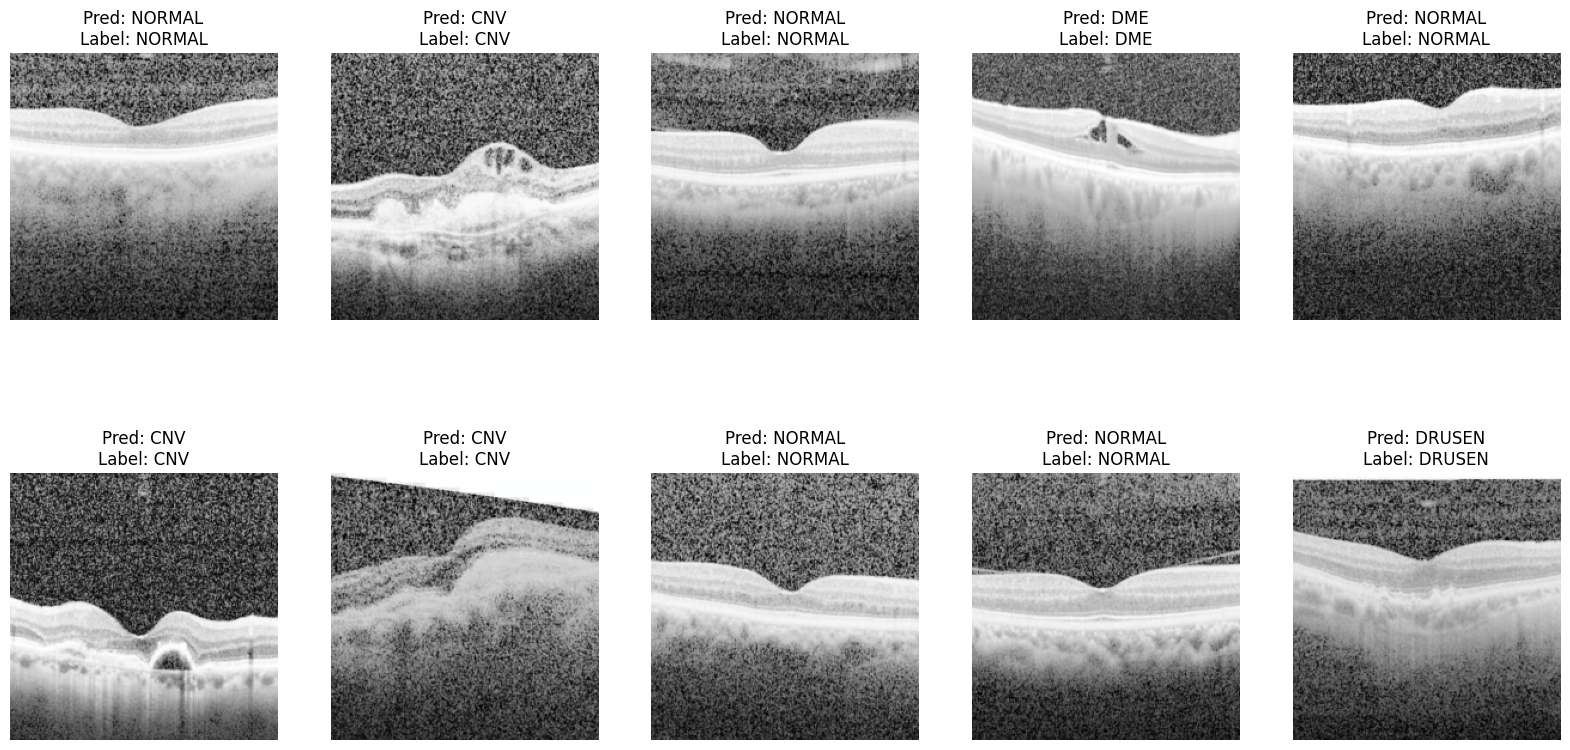

In [21]:
# Visualizar predicciones
visualize_predictions(model, test_dataloader, test_dataset.classes, num_images=10)

In [22]:
# Evaluar el modelo
accuracy, precision, recall, f1, sensitivity,cm, class_names = evaluate_model(model, test_dataloader, len(test_dataset), test_dataset.classes)

Accuracy: 0.9479
Balanced Accuracy: 0.8828
Precision: 0.9479
Recall: 0.9479
F1-score: 0.9462


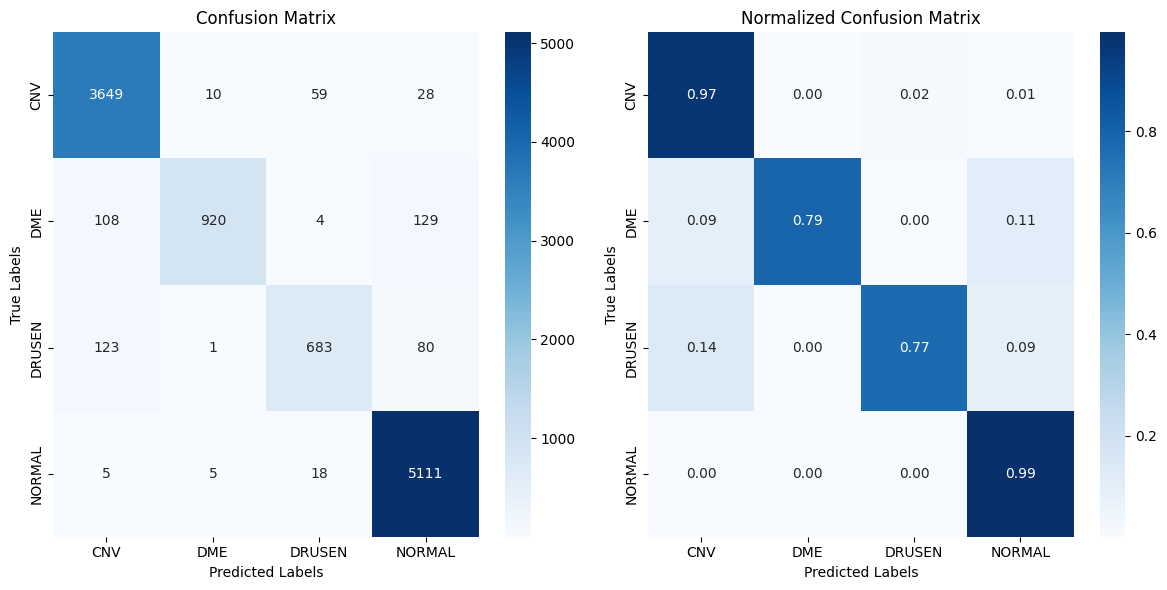

In [23]:
# Calcular la matriz de confusión
plot_confusion_matrix(cm, class_names)